# ANSWERS
Enter all of your official answers to each question here. Questions 2-5 should be answered using **first touch attribution.**

In [1]:
%%capture
################################
#### do not alter this code ####
################################

# !pip install pandas
# !pip install jupysql
# !pip install matplotlib
# !pip install click

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%capture

################################
#### do not alter this code ####
################################

ad_channel_path="data/ad_channels.csv"
clicks_path="data/clicks.csv"
locks_path="data/locks.csv"
sales_path="data/sales.csv"
spend_path="data/spend.csv"
vehicle_path="data/vehicles.csv"

ad_channels=pd.read_csv(ad_channel_path)
clicks=pd.read_csv(clicks_path)
locks=pd.read_csv(locks_path)
sales=pd.read_csv(sales_path)
spend=pd.read_csv(spend_path)
vehicles=pd.read_csv(vehicle_path)

%load_ext sql
%sql sqlite://

%sql --persist ad_channels
%sql --persist clicks
%sql --persist locks
%sql --persist sales
%sql --persist spend
%sql --persist vehicles

______________________________________________________
______________________________________________________


**We encourage that you use python for the majority of the exercise.** However, the environment has jupysql installed to allow for running inline SQL. In some questions we ask to see a SQL implementation as we use both extensively in our work. See example sql below.

Refer to the package documentation for more info on how to use: https://jupysql.ploomber.io/en/latest/api/configuration.html#style

Quick guide:
- single line sql: *%sql {sql query}*
- multi line sql: *%%sql
                  {sql query}*
- write output to object: *%% sql df_name << {sql query}*

### Prerequisite

In [3]:
# split channel name (category-partner_campaign)
ad_channels['category'] = ad_channels.channel.transform(lambda str: str[:str.find("-")])
ad_channels['partner'] = ad_channels.channel.transform(lambda str: str[str.find("-")+1: str.find("_")] if str.find("_")!=-1 else str[str.find("-")+1:])
ad_channels['campaign'] = ad_channels.channel.transform(lambda str: str[str.find("_")+1:] if str.find("_") != -1 else str[str.find("-")+1:])
ad_channels = ad_channels.set_index('channel_id') 
ad_channels.head()

,channel,category,partner,campaign
channel_id,,,,
1,Search Engine-Hooli_Convertible,Search Engine,Hooli,Convertible
2,Search Engine-Hooli_Sedan,Search Engine,Hooli,Sedan
3,Search Engine-Hooli_Truck,Search Engine,Hooli,Truck
4,Search Engine-Bam_Convertible,Search Engine,Bam,Convertible
5,Search Engine-Bam_Sedan,Search Engine,Bam,Sedan


In [4]:
# define first touch attribution
first_touch = clicks.sort_values('click_datetime')\
                    .groupby('user_id')\
                    .first()\
                    .reset_index()\
                    .join(ad_channels, on='channel_id')

first_touch['convert_to_sale'] = first_touch.user_id.isin(sales.user_id.astype('Int64').to_list())
first_touch.head()

,user_id,click_datetime,channel_id,channel,category,partner,campaign,convert_to_sale
0,10833,2022-06-21 22:17:39.543875,4,Search Engine-Bam_Convertible,Search Engine,Bam,Convertible,False
1,13887,2022-07-15 07:59:13.644703,13,Social Media-KnickKnack,Social Media,KnickKnack,KnickKnack,False
2,13963,2022-07-07 19:22:56.553279,15,Third Party Listing-RealTruck,Third Party Listing,RealTruck,RealTruck,False
3,14696,2022-10-30 14:52:08.135901,2,Search Engine-Hooli_Sedan,Search Engine,Hooli,Sedan,False
4,15249,2022-08-17 03:17:05.901867,13,Social Media-KnickKnack,Social Media,KnickKnack,KnickKnack,False


In [5]:
# clicks table configuration
clicks.click_datetime = pd.to_datetime(clicks.click_datetime)

# sales table configuration
sales.user_id = sales.user_id.astype('Int64')
sales.sale_datetime = pd.to_datetime(sales.sale_datetime)
sales['year'] = sales.sale_datetime.dt.year
sales['month'] = sales.sale_datetime.dt.month

# converted sales under first touch attibution
converted_sales = first_touch.join(sales.set_index('user_id'), on='user_id', how='inner')
converted_sales.head()

,user_id,click_datetime,channel_id,channel,category,partner,campaign,convert_to_sale,lock_id,sale_datetime,sale_id,make,model,has_trade_in,is_financed,apr,delivery_distance,year,month
21,38769,2022-09-18 00:05:08.000000000,5,Search Engine-Bam_Sedan,Search Engine,Bam,Sedan,True,26334269,2022-10-29 00:16:00,1624686,Subaru,Forester,0,0,NaN,659,2022,10
79,99994,2022-10-16 08:55:37.000000000,10,Online Video-WeTube_25+,Online Video,WeTube,25+,True,26423056,2022-11-11 13:11:00,1641936,Land Rover,Range Rover,0,0,NaN,631,2022,11
91,112497,2022-08-27 21:52:59.000000000,15,Third Party Listing-RealTruck,Third Party Listing,RealTruck,RealTruck,True,26120673,2022-11-03 14:33:00,1628000,Ford,Mustang,0,0,NaN,941,2022,11
121,135937,2022-10-19 04:23:17.000000000,6,Search Engine-Bam_Truck,Search Engine,Bam,Truck,True,27526924,2022-12-22 21:26:00,1683483,Chevrolet,Silverado,0,0,NaN,517,2022,12
125,139005,2022-10-09 13:51:43.000000000,2,Search Engine-Hooli_Sedan,Search Engine,Hooli,Sedan,True,26274535,2022-10-26 22:55:00,1624760,Chevrolet,Malibu,0,0,NaN,1171,2022,10


### Q1: What category of channel has the lowest cost per click? Why do you think this channel has the lowest CPC? (complete in both python and SQL)

In [6]:
# groupby channel_id
spend_by_channel = spend.groupby('channel_id').sum()[['spend']]
clicks_by_channel = clicks.groupby('channel_id').count()[['user_id']].rename(columns={'user_id': 'clicks'})

# groupby category
calc_cpc = pd.concat([spend_by_channel, clicks_by_channel], axis=1)\
                .join(ad_channels, on='channel_id')\
                .groupby('category')\
                .sum()[['spend', 'clicks']]

# calculate CPC
calc_cpc['cpc'] = (calc_cpc.spend / calc_cpc.clicks).round(3)
calc_cpc = calc_cpc.sort_values(by='cpc')
calc_cpc.head()

,spend,clicks,cpc
category,,,
Search Engine,119000.09,94591,1.258
Social Media,29999.99,22797,1.316
Online Video,39500.06,18483,2.137
Third Party Listing,62500.08,21032,2.972
Finance Partnership,38500.04,12004,3.207


In [7]:
# output
category = calc_cpc.cpc.idxmin()
min_cpc = calc_cpc.cpc.min()
print(f'{category} has the lowest cost per click {min_cpc:.2f}')

Search Engine has the lowest cost per click 1.26


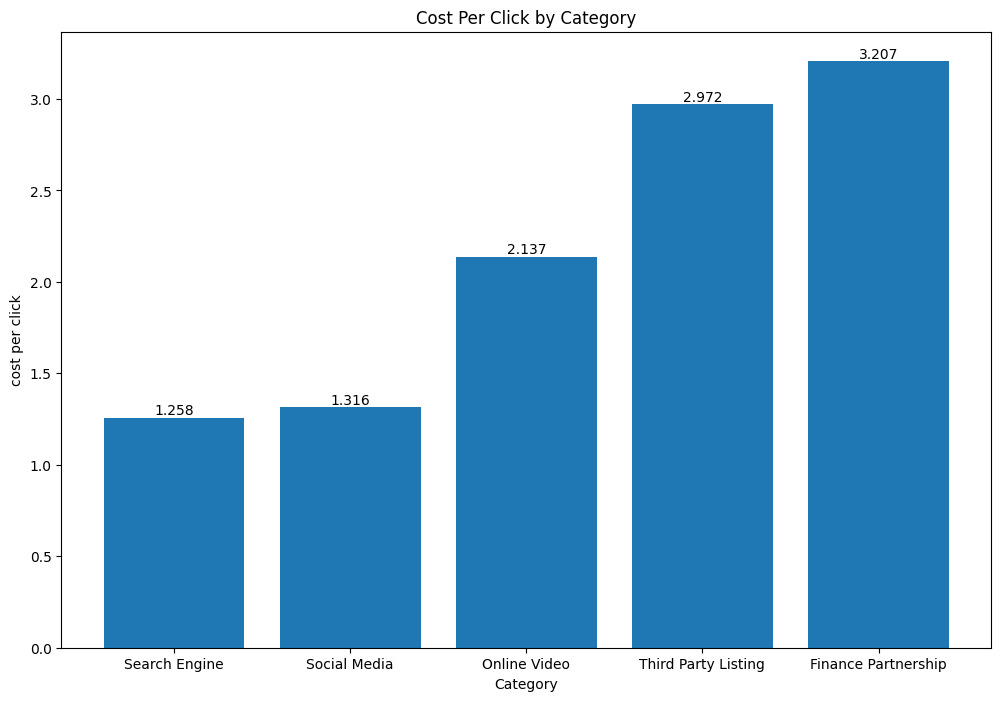

In [8]:
plt.figure(figsize=(12,8))
bar = plt.bar(x=calc_cpc.index, height=calc_cpc['cpc'])
plt.bar_label(bar, calc_cpc['cpc'])
plt.title('Cost Per Click by Category')
plt.xlabel('Category')
plt.ylabel('cost per click')
plt.show()

In [9]:
%%sql
WITH spend_temp AS (
    SELECT channel_id, SUM(spend) AS spend_sum FROM spend GROUP BY channel_id
), clicks_temp AS (
    SELECT channel_id, COUNT(1) AS clicks_count FROM clicks GROUP BY channel_id
), category AS (
    SELECT channel_id, SUBSTR(channel, 0, INSTR(channel, "-")) AS category 
    FROM ad_channels
)
SELECT 
    g.category,
    SUM(s.spend_sum) AS total_spend,
    SUM(c.clicks_count) AS total_clicks,
    ROUND(SUM(s.spend_sum)/SUM(c.clicks_count), 3) AS cpc
FROM category g
JOIN spend_temp s ON g.channel_id = s.channel_id
JOIN clicks_temp c ON g.channel_id = c.channel_id
GROUP BY 1
ORDER BY 4 ASC
-- LIMIT 1

Running query in 'sqlite://'

category,total_spend,total_clicks,cpc
Search Engine,119000.09,94591,1.258
Social Media,29999.99,22797,1.316
Online Video,39500.06,18483,2.137
Third Party Listing,62500.08,21032,2.972
Finance Partnership,38500.04,12004,3.207


### Q2: What are the top three campaigns in terms of number of sales generated by first touch attribution? (complete in both python and SQL)

In [10]:
# whether convert to sales
first_touch['convert_to_sales'] = first_touch.user_id.isin(sales.user_id.astype('Int64').to_list())

# groupby campaign
sales_by_campaign = first_touch.groupby('campaign')\
                                .sum(numeric_only=True)[['convert_to_sales']]\
                                .sort_values(by='convert_to_sales', ascending=False)
sales_by_campaign.head(3)

,convert_to_sales
campaign,
Sedan,265
Convertible,187
25+,175


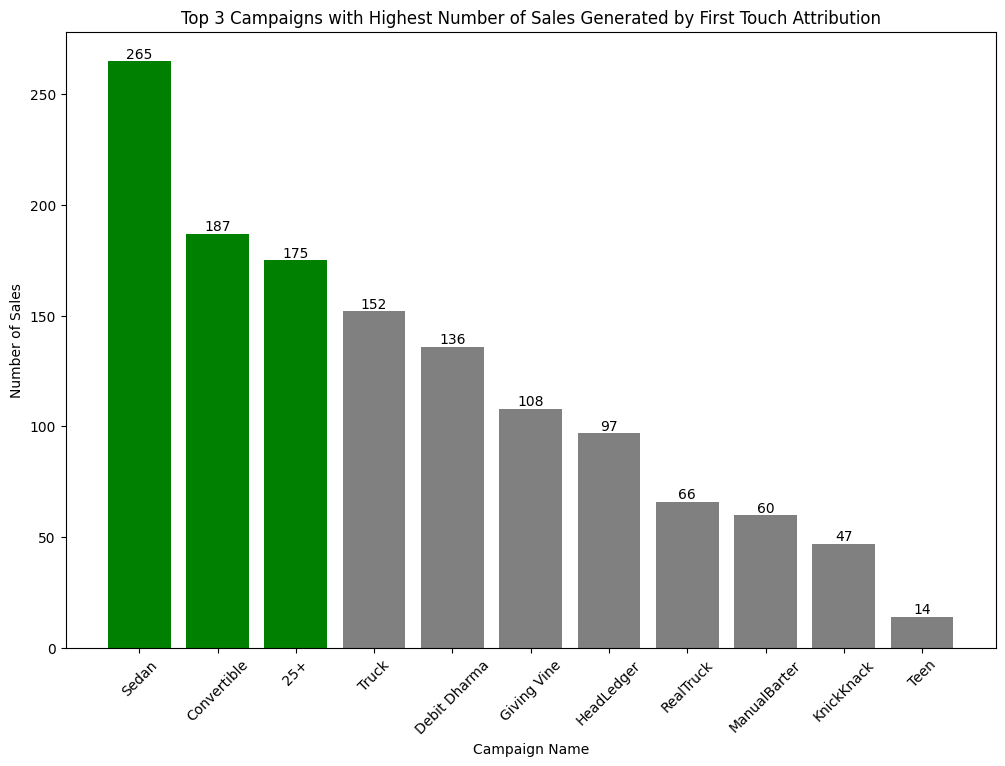

In [11]:
indices = sales_by_campaign.index
top_indices = range(3)
colors = ['green' if i in top_indices else 'gray' for i in range(len(indices))]

plt.figure(figsize=(12,8))
bar = plt.bar(x=sales_by_campaign.index, height=sales_by_campaign['convert_to_sales'], color=colors)
plt.bar_label(bar, label_type='edge')
plt.title('Top 3 Campaigns with Highest Number of Sales Generated by First Touch Attribution')
plt.xlabel('Campaign Name')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.show()

In [12]:
%%sql
WITH first_touch_by_channel AS (
    SELECT DISTINCT
        user_id,
        first_value(channel_id) OVER (PARTITION BY user_id ORDER BY click_datetime) AS first_touch_channel
    FROM clicks
), campaign AS (
    SELECT channel_id, 
        CASE WHEN INSTR(channel, "_") != 0
            THEN SUBSTR(channel, INSTR(channel, "_")+1)
            ELSE SUBSTR(channel, INSTR(channel, "-")+1)
        END AS campaign
    FROM ad_channels
)
SELECT
    c.campaign,
    COUNT(1) AS convert_to_sale
FROM first_touch_by_channel f
JOIN sales s ON f.user_id = s.user_id
JOIN campaign c ON f.first_touch_channel = c.channel_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 3

Running query in 'sqlite://'

campaign,convert_to_sale
Sedan,265
Convertible,187
25+,175


### Q3: Which campaigns had the most month over month growth/decline in number of sales generated from Oct to Dec?

In [13]:
# get daily_sales from converted_sales table
daily_sales = converted_sales[['campaign', 'year', 'month', 'sale_id']].copy()

# extract month
daily_sales['year_month'] = daily_sales.year.astype('str') + "-" + daily_sales.month.astype('str')

# pivot table
monthly_sales = pd.pivot_table(daily_sales, values='sale_id', index='campaign', columns='year_month', aggfunc='count', fill_value=0)\
                    .drop(columns=['2022-9', '2023-1', '2023-4'])
monthly_sales

year_month,2022-10,2022-11,2022-12
campaign,,,
25+,59,36,55
Convertible,76,28,34
Debit Dharma,44,16,32
Giving Vine,41,11,27
HeadLedger,30,20,25
KnickKnack,24,12,11
ManualBarter,22,10,23
RealTruck,29,10,27
Sedan,89,27,38


In [14]:
# calculate MoM growth
MoM = pd.DataFrame()
MoM['Oct_Nov'] = (((monthly_sales['2022-11'] - monthly_sales['2022-10'])/monthly_sales['2022-10'])*100).round(2)
MoM['Nov_Dec'] = (((monthly_sales['2022-12'] - monthly_sales['2022-11'])/monthly_sales['2022-11'])*100).round(2)
MoM['abs_diff'] = (MoM['Nov_Dec'] - MoM['Oct_Nov'])
MoM = MoM.sort_values('abs_diff', ascending=False)
MoM

,Oct_Nov,Nov_Dec,abs_diff
campaign,,,
RealTruck,-65.52,170.00,235.52
Giving Vine,-73.17,145.45,218.62
ManualBarter,-54.55,130.00,184.55
Debit Dharma,-63.64,100.00,163.64
Truck,-60.00,58.33,118.33
Sedan,-69.66,40.74,110.40
25+,-38.98,52.78,91.76
Convertible,-63.16,21.43,84.59
HeadLedger,-33.33,25.00,58.33


In [15]:
# output
most_growth_campaign = MoM['Oct_Nov'].idxmax() if MoM['Oct_Nov'].max() > MoM['Nov_Dec'].max() else MoM['Nov_Dec'].idxmax()
most_decline_campaign = MoM['Oct_Nov'].idxmin() if MoM['Oct_Nov'].min() < MoM['Nov_Dec'].min() else MoM['Nov_Dec'].idxmin()

growth = MoM['Oct_Nov'].max() if MoM['Oct_Nov'].max() > MoM['Nov_Dec'].max() else MoM['Nov_Dec'].max()
decline = MoM['Oct_Nov'].min() if MoM['Oct_Nov'].min() < MoM['Nov_Dec'].min() else MoM['Nov_Dec'].min()

print(
f"""
Most Month-Over-Month Growth
Campaign: {most_growth_campaign}
Growth (Nov-Dec): {growth}%

Most Month-Over-Month Decline
Campaign: {most_decline_campaign}
Decline (Oct-Nov): {decline}%
""")


Most Month-Over-Month Growth
Campaign: RealTruck
Growth (Nov-Dec): 170.0%

Most Month-Over-Month Decline
Campaign: Teen
Decline (Oct-Nov): -100.0%



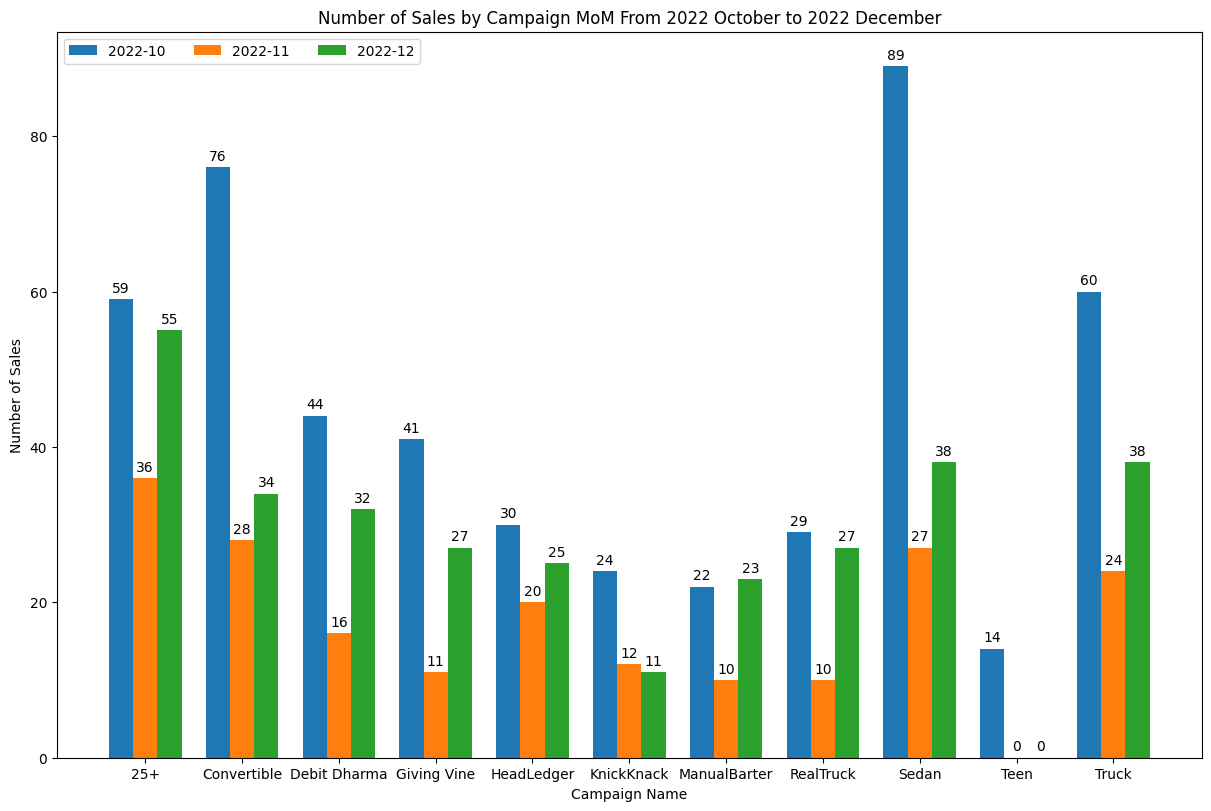

In [16]:
fig, ax = plt.subplots(figsize=(12, 8), layout='constrained')

x = np.arange(monthly_sales.shape[0])
width = 0.25
multipler = 0

campaigns = monthly_sales.index.values

for col in monthly_sales.columns:
    offset = width * multipler
    value = monthly_sales.reset_index()[col].values
    rects = ax.bar(x+offset, height=value, width=width, label=col)
    ax.bar_label(rects, padding = 3)
    multipler += 1

ax.set_title('Number of Sales by Campaign MoM From 2022 October to 2022 December')
ax.set_xlabel('Campaign Name')
ax.set_ylabel('Number of Sales')
ax.set_xticks(x + width, campaigns)
ax.legend(loc='upper left', ncols=3)
plt.show()

In [17]:
# fig, ax = plt.subplots(figsize=(12, 8), layout='constrained')
# plt.plot(monthly_sales.T)
# plt.title('Number of Sales by Campaign')
# plt.ylabel('Number of Sales')
# plt.legend(labels=monthly_sales.index)
# plt.show()

### Q4: Which partner is the most cost efficient, i.e., has the lowest CAC

In [18]:
# spend groupby partner
spend_by_partner = spend_by_channel.join(ad_channels).groupby('partner').sum()[['spend']]

# sales groupby partner
sales_by_partner = converted_sales.groupby('partner').sum(numeric_only=True)[['convert_to_sale']]

# calculate CAC
calc_cac = spend_by_partner.join(sales_by_partner)
calc_cac['cac'] = (calc_cac.spend / calc_cac.convert_to_sale).round(2)
calc_cac = calc_cac.sort_values('cac')
calc_cac.head()

,spend,convert_to_sale,cac
partner,,,
Debit Dharma,19999.99,137,145.99
Giving Vine,18500.05,108,171.30
Hooli,80000.05,423,189.13
Datankle,20000.02,98,204.08
HeadLedger,19999.95,97,206.19


In [19]:
# output
min_cac = calc_cac.cac.min()
cost_efficient_partner = calc_cac.cac.idxmin()
print(f'{cost_efficient_partner} is the most cost efficient partner, has the lowest CAC {min_cac}')

Debit Dharma is the most cost efficient partner, has the lowest CAC 145.99


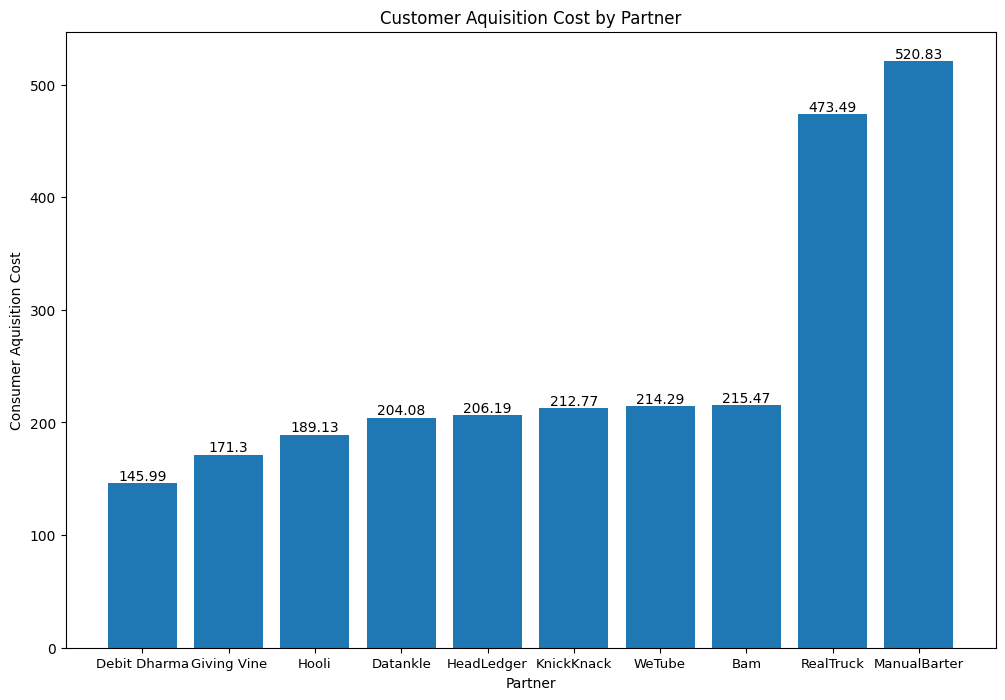

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
bar = plt.bar(x=calc_cac.index, height=calc_cac['cac'])
plt.title('Customer Aquisition Cost by Partner')
plt.bar_label(bar, calc_cac['cac'])
plt.xlabel('Partner')
plt.ylabel('Consumer Aquisition Cost')
plt.xticks(fontsize=9.5)
plt.show()

### Q5: Which category of channel has the best ROI? The worst? (please reference ROI formula and profit calculation)

In [21]:
# calculate monthly average apr for financed car 
monthly_avg_apr_finance = sales.groupby(['year', 'month', 'is_financed'])\
                                .mean(numeric_only=True)[['apr']]\
                                .rename(columns={'apr': 'avg_apr_finance'})\
                                .fillna(0)

# join monthly_avg_apr_finance and vehicles
calc_gross_profit = converted_sales[['year', 'month', 'category', 'make', 'model', 'is_financed', 'apr', 'has_trade_in', 'delivery_distance']].copy()
calc_gross_profit = calc_gross_profit.join(monthly_avg_apr_finance, on=['year', 'month', 'is_financed'])\
                                    .join(vehicles.set_index(['make', 'model']), on=['make', 'model'])\
                                    .fillna(0)

# calculate gross profit
calc_gross_profit['apr_modifier'] = ((calc_gross_profit.apr - calc_gross_profit.avg_apr_finance)/calc_gross_profit.avg_apr_finance).fillna(-0.1)
calc_gross_profit['modified_starting_value'] = calc_gross_profit.avg_margin * (1 + calc_gross_profit.apr_modifier)


def condition(df):
    if df['bodystyle'] in ['Sedan', 'Hatchback']:
        return df['modified_starting_value'] + 200 - 0.5*df['delivery_distance'] + df['has_trade_in']*400
    elif df['bodystyle'] in ['Coupe', 'SUV']:
        return df['modified_starting_value'] -  0.8*df['delivery_distance'] + df['has_trade_in']*300
    elif df['bodystyle'] == 'Truck':
       return df['modified_starting_value'] - 200 - df['delivery_distance'] + df['has_trade_in']*200

calc_gross_profit['gross_profit'] = calc_gross_profit.apply(condition, axis=1)

# profit groupby category
profit_by_category = calc_gross_profit.groupby('category').sum(numeric_only=True)[['gross_profit']]

# spend groupby category
spend_by_category = spend.set_index('channel_id')\
                        .join(ad_channels[['category']], on='channel_id')\
                        .groupby('category').sum()[['spend']]

# merge
calc_roi = profit_by_category.join(spend_by_category, on='category')
calc_roi['roi'] = (calc_roi.gross_profit / calc_roi.spend).round(2)
calc_roi = calc_roi.sort_values('roi', ascending=False)
calc_roi.head()

,gross_profit,spend,roi
category,,,
Finance Partnership,88819.029353,38500.04,2.31
Search Engine,200140.659175,119000.09,1.68
Social Media,44967.994393,29999.99,1.50
Online Video,50479.194535,39500.06,1.28
Third Party Listing,17264.423000,62500.08,0.28


In [22]:
# output
best_roi = calc_roi.roi.max()
best_roi_category = calc_roi.roi.idxmax()
print(f'The best category is {best_roi_category} and roi is {best_roi}')

The best category is Finance Partnership and roi is 2.31


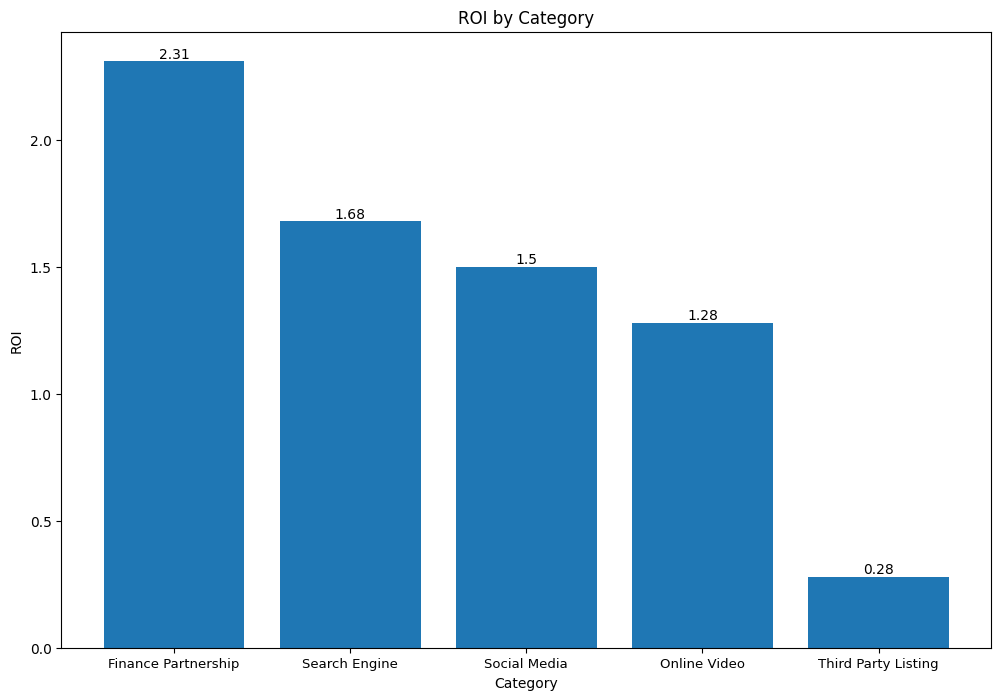

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
bar = plt.bar(x=calc_roi.index, height=calc_roi['roi'])
plt.title('ROI by Category')
plt.bar_label(bar, calc_roi['roi'])
plt.xlabel('Category')
plt.ylabel('ROI')
plt.xticks(fontsize=9.5)
plt.show()

### Q6: On average, how many different channels do customers interact with prior to locking a car?

In [24]:
import numpy as np
clicks['whether_lock'] = clicks.user_id.isin(locks.user_id.to_list())
channel_count_by_user = clicks[clicks.whether_lock == True].groupby('user_id').nunique()[['channel_id']]
channel_count_by_user.head()

#output
avg_channel_n = int(channel_count_by_user.mean().get('channel_id'))
print(f'On average, customers interact with {avg_channel_n} different channels prior to locking a car.')

On average, customers interact with 4 different channels prior to locking a car.


### Q7: What percentage of sales don't have a click within 90 days prior to the conversion? How can you explain this?

In [25]:
clicks_conversion = sales.join(clicks.set_index('user_id'), on='user_id')[['sale_id','sale_datetime', 'click_datetime']].copy()
clicks_conversion['click_within_90_days'] = pd.to_timedelta(clicks_conversion.sale_datetime - clicks_conversion.click_datetime, unit='day') <= pd.to_timedelta('90 days')
n_sales_no_clicks_wihtin_90_days = int(clicks_conversion[clicks_conversion.click_within_90_days == False].sale_id.nunique())
total_sales = int(sales.sale_id.count())
sales_no_click_90_days_pct = (n_sales_no_clicks_wihtin_90_days / total_sales)*100
print(f"{sales_no_click_90_days_pct:.2f}% of sales don't have a click within 90 days prior to the conversion.")

31.23% of sales don't have a click within 90 days prior to the conversion.


**Explaination**

It suggests that some conversations weren't directly attributed to recent marketing paid campaigns through channels. Here are some possible explainations:


1. Offline Influence:
    - Customers may have been influenced by offline marketing channels (e.g., word-of-mouth, in-store visits, TV ads) that aren’t tracked digitally.
    - Brand loyalty or past experiences may drive some purchases without the need for recent online engagement.
2. Delayed Decision-Making:
    - Customers might have interacted with your brand earlier (before the 90-day window) and only recently decided to purchase.
3. Direct Traffic or Organic Search:
    - Some users may bypass ads altogether and visit your website directly or through organic search because they already know the brand.
4. Email or Referral Traffic:
    - Users may follow links from emails, saved bookmarks, or referrals that aren't tagged for tracking.
5. Cookie Expiration or Tracking Gaps:
    - Some tracking tools might have gaps, especially if cookies expired, were deleted, or if users switched devices.
6. Impulse Buying or Repeat Customers:
    - Repeat buyers who are already familiar with the product may skip the typical browsing journey and head straight to purchase.

### Q8: Based on what you know about channel performance, what recommendation would you give for re-allocating spend given we are increasing budget by 20% next year? Please provide supporting rationale.

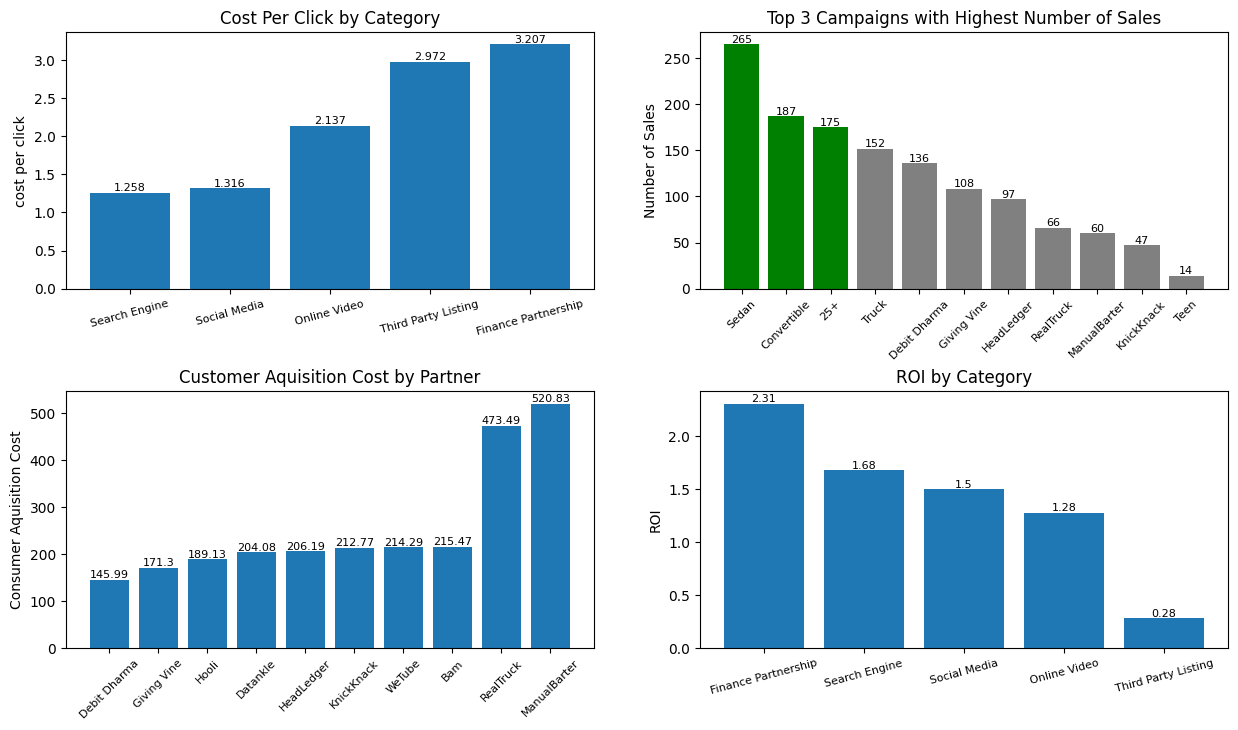

In [26]:
plt.figure(figsize=(15,8))

# cpc
plt.subplot(221)
bar = plt.bar(x=calc_cpc.index, height=calc_cpc['cpc'])
plt.bar_label(bar, calc_cpc['cpc'], fontsize=8)
plt.title('Cost Per Click by Category')
plt.ylabel('cost per click')
plt.xticks(fontsize=8, rotation=15)

# top 3 campaign
plt.subplot(222)
bar = plt.bar(x=sales_by_campaign.index, height=sales_by_campaign['convert_to_sales'], color=colors)
plt.bar_label(bar, label_type='edge', fontsize=8)
plt.title('Top 3 Campaigns with Highest Number of Sales')
plt.ylabel('Number of Sales')
plt.xticks(fontsize=8, rotation=45)

# cac
plt.subplot(223)
bar = plt.bar(x=calc_cac.index, height=calc_cac['cac'])
plt.title('Customer Aquisition Cost by Partner')
plt.bar_label(bar, calc_cac['cac'], fontsize=8)
plt.ylabel('Consumer Aquisition Cost')
plt.xticks(fontsize=8, rotation=45)

# roi
plt.subplot(224)
bar = plt.bar(x=calc_roi.index, height=calc_roi['roi'])
plt.title('ROI by Category')
plt.bar_label(bar, calc_roi['roi'], fontsize=8)
plt.ylabel('ROI')
plt.xticks(fontsize=8, rotation=15)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

**Recommended Actions by Channel/Partner/Campaign**

1. Search Engine (Strong Performance)
    - Campaigns to Prioritize:
        - ✅ Sedan (Top-performing in sales)
        - ✅ Convertible (Second-highest in sales)

    - Partners to Prioritize:
        - ✅ Bam (Appears twice in key campaigns)
        - ✅ Hooli (Has key campaigns with strong performance)

    - 💰 Increase budget for both Bam and Hooli campaigns, especially targeting Sedan and Convertible.

2. Finance Partnership (High ROI but Mixed CAC)
    - Campaigns to Prioritize:
        - ✅ Debit Dharma (Best CAC at $145.99)
        - ✅ Giving Vine (Second-best CAC at $171.3)
    - 💰 Increase budget here — strong ROI and cost-effective acquisition.

3. Online Video (Moderate ROI and Higher CPC)
    - Campaigns to Prioritize:
        - ✅ Datankle - 25+ (Part of the top 3 campaigns in sales)
    - Campaigns to Scale Down or Optimize:
        - Teen (Both WeTube and Datankle versions show weak performance) ❗️
    - 🔍 Shift focus to the '25+' campaign and reduce investment in the 'Teen' campaigns unless revised targeting shows improvement.

4. Social Media (Decent ROI but No Top-Sales Campaigns)
    - Campaigns to Prioritize:
        - 🔍 Monitor HeadLedger closely — while not a top-performing campaign, it may be worth further testing.
        - KnickKnack is underperforming; consider reducing spend❗️

5. Third Party Listing (Low ROI & High CAC)
    - Campaigns to Scale Down or Pause:
        - RealTruck and ManualBarter — High CAC and weak ROI suggest budget cuts unless strategic reasons justify their continuation❗️ 

**Summary of Budget Allocation Strategy:**
-  Increase Budget ✅:
    - Search Engine (Sedan + Convertible campaigns)
    - Finance Partnership (Debit Dharma + Giving Vine campaigns)
    - Online Video (Datankle - 25+)
- Reduce Budget / Optimize❗️ :
    - Online Video (Teen campaigns)
    - Social Media (KnickKnack)
    - Third Party Listings (Both campaigns unless performance improves)